In [1]:
import h5py
import itertools
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

from neuropacks import ECOG
from uoineuro.utils import plot_metric_summary
from uoineuro.tuning_utils import calculate_best_frequencies_ecog
from uoineuro.coupling_utils import check_metrics, create_symmetrized_graph

%matplotlib inline

In [2]:
# insert path to data and grid here
data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')

# data_path = '/storage/data/ecog/r32_b7.mat'
# grid_path = '/storage/data/ecog/grdid.mat'

In [3]:
ecog = ECOG(data_path=data_path, grid_path=grid_path)

In [4]:
coupling_fits_path = os.path.join(
    os.environ['HOME'], 'fits/uoineuro/coupling/ecog/ecog_coupling.h5'
)

tuning_fits_path = os.path.join(
    os.environ['HOME'], 'fits/uoineuro/tuning/ecog/ecog_tuning.h5'
)

In [5]:
coupling_fits = h5py.File(coupling_fits_path, 'r')
tuning_fits = h5py.File(tuning_fits_path, 'r')

In [6]:
baseline = coupling_fits['lasso']
algorithms = [coupling_fits['uoi_lasso_r2'],
              coupling_fits['uoi_lasso_aic'],
              coupling_fits['uoi_lasso_bic']]

In [7]:
dead_electrodes = [0, 19, 21]

# Metric Comparison

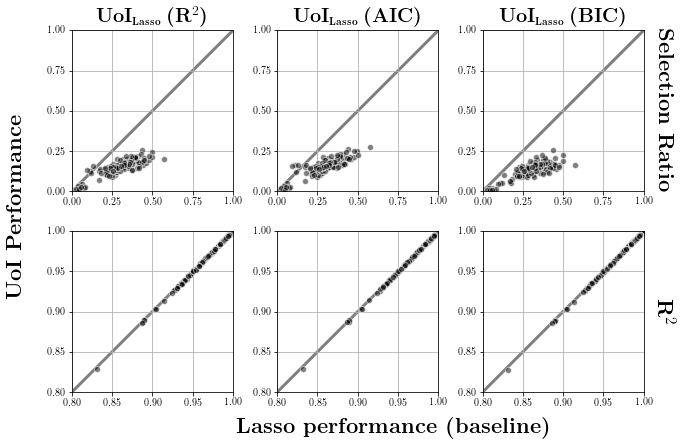

In [8]:
fig, axes = plot_metric_summary(baseline_group=baseline,
                                fits_groups=algorithms,
                                metrics=['selection_ratio', 'r2s_test'],
                                omit_idxs=dead_electrodes)

# additional customizations 

# first row: selection ratio
for idx in range(3):
    ax = axes[0, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.grid('on')

# second row: r2
for idx in range(3):
    ax = axes[1, idx]
    ax.set_xlim([0.80, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0.8, 0.85, 0.9, 0.95, 1])
    ax.set_yticks([0.8, 0.85, 0.9, 0.95, 1])
    ax.grid('on')
    
for ax in axes.ravel():
    ax.set_axisbelow(True)
    ax.tick_params(labelsize=10)
    
# metric labels
axes[0, -1].set_ylabel(
    r'\textbf{Selection Ratio}',
    fontsize=22,
    labelpad=30,
    rotation=270)
axes[1, -1].set_ylabel(
    r'$\mathbf{R}^2$',
    fontsize=22,
    labelpad=30,
    rotation=270)
axes[0, -1].yaxis.set_label_position('right')
axes[1, -1].yaxis.set_label_position('right')

# uoi approach labels
axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(BIC)}',
                     fontsize=20)

fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{Lasso performance (baseline)}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{UoI Performance}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()

plt.savefig('ecog_coupling_metric_summary.pdf', bbox_inches='tight')

# Graph Comparison

In [9]:
lasso_median_coefs = np.median(coupling_fits['lasso/coupling_coefs'], axis=0)
uoi_median_coefs = np.median(coupling_fits['uoi_lasso_bic/coupling_coefs'], axis=0)

In [10]:
positions = {}

for electrode in range(ecog.n_electrodes):
    x, y = ecog.get_xy_for_electrode(electrode)
    positions[electrode] = (y, -x)

In [11]:
G_lasso, weights_dict_lasso = create_symmetrized_graph(
    coupling_coefs=lasso_median_coefs,
    omit_idxs=dead_electrodes,
    transform=None)

In [12]:
G_uoi, weights_dict_uoi = create_symmetrized_graph(
    coupling_coefs=uoi_median_coefs,
    omit_idxs=dead_electrodes,
    transform=None)

In [13]:
pref_freq_lasso = calculate_best_frequencies_ecog(
    np.mean(tuning_fits['lasso/tuning_coefs'][:], axis=0),
    ecog,
    return_grid=False,
    omit_idxs=dead_electrodes)

pref_freq_uoi = calculate_best_frequencies_ecog(
    np.mean(tuning_fits['uoi_lasso_bic/tuning_coefs'][:], axis=0),
    ecog,
    return_grid=False,
    omit_idxs=dead_electrodes)

In [14]:
pref_log_freq_lasso = np.log(pref_freq_lasso)
pref_log_freq_lasso = pref_log_freq_lasso[pref_log_freq_lasso != -np.inf]

pref_log_freq_uoi = np.log(pref_freq_uoi)
pref_log_freq_uoi = pref_log_freq_uoi[pref_log_freq_uoi != -np.inf]

In [15]:
cmap_vals_lasso = (255 * (pref_log_freq_lasso - ecog.log_freq_set[0]) / (ecog.log_freq_set[-1] - ecog.log_freq_set[0])).astype('int')
cmap_vals_uoi = (255 * (pref_log_freq_uoi - ecog.log_freq_set[0]) / (ecog.log_freq_set[-1] - ecog.log_freq_set[0])).astype('int')

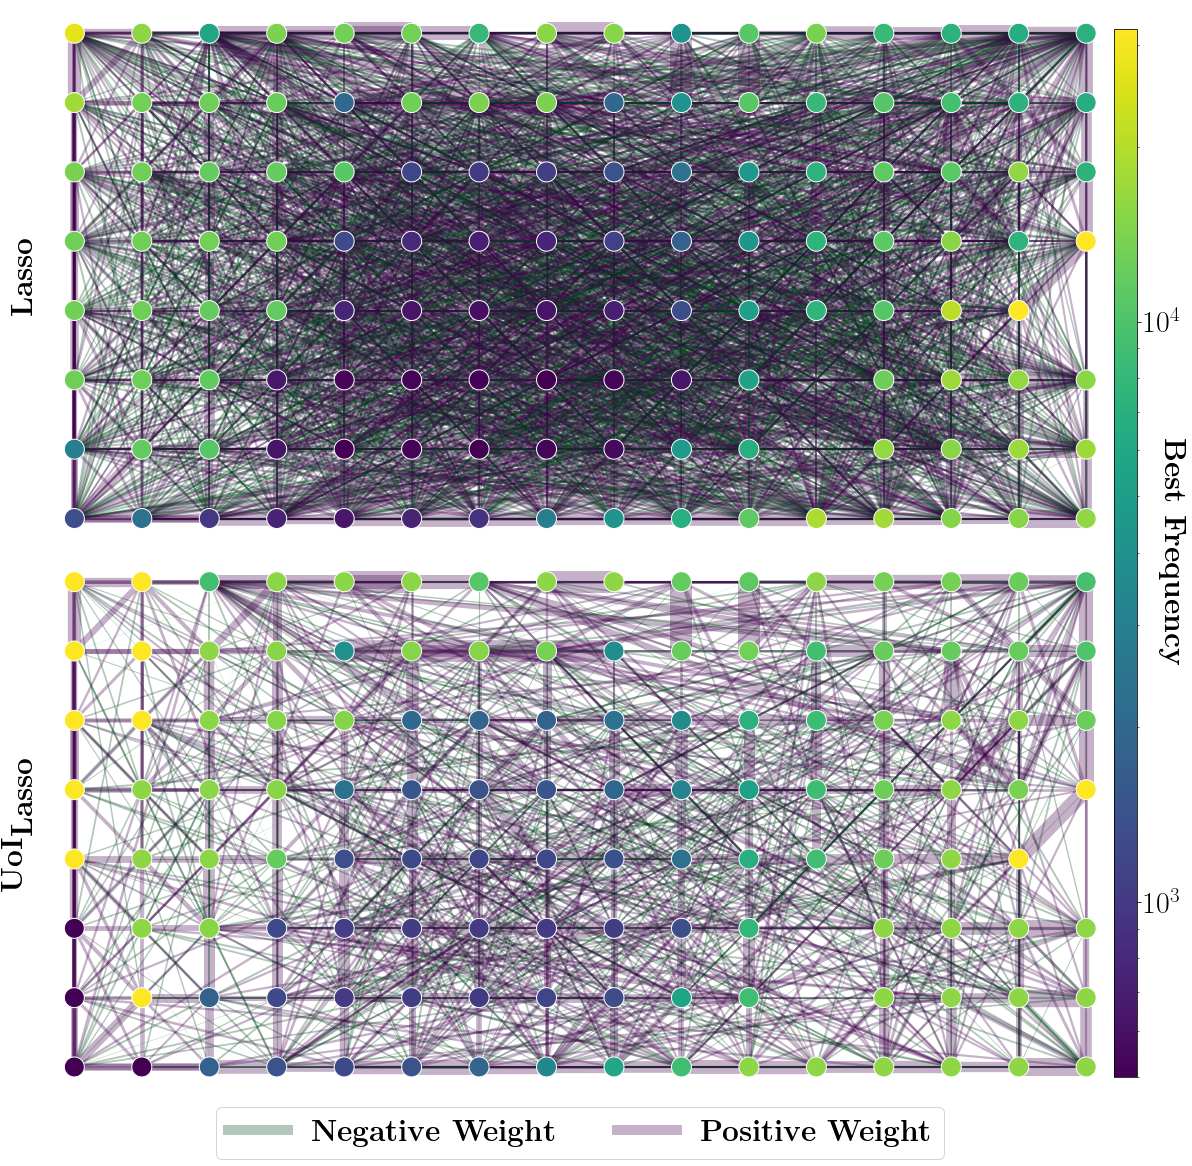

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(16, 16))

weight_list_lasso = np.array(list(weights_dict_lasso.values()))
weight_list_uoi = np.array(list(weights_dict_uoi.values()))

# draw lasso graph
nx.draw_networkx_nodes(
    G=G_lasso,
    pos=positions,
    node_size=400,
    nodelist=list(np.setdiff1d(np.arange(ecog.n_electrodes), dead_electrodes)),
    node_color=cmap_vals_lasso,
    edgecolors='w',
    cmap=plt.get_cmap('viridis'),
    ax=axes[0])

nx.draw_networkx_edges(
    G=G_lasso,
    pos=positions,
    width=2.0 + 20 * weight_list_lasso,
    alpha=0.30,
    edge_color=np.sign(weight_list_lasso),
    edge_cmap=plt.get_cmap('PRGn_r'),
    edge_vmin=-1,
    edge_vmax=1,
    ax=axes[0])

# draw UoI graph
nx.draw_networkx_nodes(
    G=G_uoi,
    pos=positions,
    node_size=400,
    nodelist=list(np.setdiff1d(np.arange(ecog.n_electrodes), dead_electrodes)),
    node_color=cmap_vals_uoi,
    edgecolors='w',
    cmap=plt.get_cmap('viridis'),
    ax=axes[1])

nx.draw_networkx_edges(
    G=G_uoi,
    pos=positions,
    width=2.0 + 20 * weight_list_uoi,
    alpha=0.30,
    edge_color=np.sign(weight_list_uoi),
    edge_cmap=plt.get_cmap('PRGn_r'),
    edge_vmin=-1,
    edge_vmax=1,
    ax=axes[1])

# color bar
cax = fig.add_axes([0.97, 0.062, 0.02, 0.91])
cb = fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=ecog.freq_set[0],
                                                                vmax=ecog.freq_set[-1]),
                                 cmap='viridis'),
    ticks=[1000, 10000],
    cax=cax,
    orientation='vertical')
cb.set_label(r'\textbf{Best Frequency}',
             fontsize=30,
             rotation=270)
cb.ax.tick_params(labelsize=30)

axes[0].set_ylabel(r'\textbf{Lasso}',
                   fontsize=30,
                   labelpad=-15)
axes[1].set_ylabel(r'\textbf{UoI}$_{\textbf{Lasso}}$',
                   fontsize=30,
                   labelpad=-15)
axes[1].plot(0, 0,
             color=plt.get_cmap('PRGn_r')(1),
             label=r'\textbf{Negative Weight}',
             linewidth=10,
             alpha=0.3)
axes[1].plot(0, 0,
             color=plt.get_cmap('PRGn_r')(255),
             label=r'\textbf{Positive Weight}',
             linewidth=10,
             alpha=0.3)

lgd = axes[1].legend(
    loc='lower center', bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    prop={'size': 30}
)


for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.savefig('ecog_coupling_grid.pdf', bbox_inches='tight')
plt.show()